In [1]:
import sys
import os

# Get the path to the validate_assay folder
module_path = os.path.abspath(os.path.join('..', 'validate_assay'))

# Add the folder to the system path
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pcrvalidationtools import *

In [3]:
# files 
DATA_PATH = "../Data/v4_08262024/"
datasets_file = DATA_PATH + 'ev_metadata_filtered.tsv'
assay1_file = DATA_PATH + 'ev_db/' + 'assay0.tsv'
assay2_file = DATA_PATH + 'ev_db/' + 'assay8.tsv'
assay3_file = DATA_PATH + 'ev_db/' + 'assay1.tsv'
assay4_file = DATA_PATH + 'ev_db/' + 'assay2.tsv'
collapse_file = DATA_PATH + 'ev_taxonomy_collapse.tsv'

In [4]:
# Retreive enterovirus, taxonomy group data
ev_data = pd.read_csv(datasets_file, sep='\t')
collapse_info = pd.read_csv(collapse_file, sep='\t')

# Assay info 
assays = [assay1_file, assay2_file, assay3_file, assay4_file]
assay_names = [f'Assay {i}' for i in [1, 2, 3, 4]]

In [5]:
def get_mismatches(assay_file, database_df):
    df = pd.read_csv(assay_file, sep='\t')
    df = df.drop_duplicates(subset=['Full_Hit_ID'], keep='first')
    
    accessions = df['Full_Hit_ID'].str.split(' ').str[0]
    mismatch_counts = df['FP_mismatches'] + df['RP_mismatches'] + df['Probe_mismatches']
    
    mismatch_df = pd.DataFrame({'Accession': accessions, 'Total Mismatches': mismatch_counts})
    
    # remove non targets 
    mismatch_df = mismatch_df[mismatch_df['Accession'].isin(database_df['Accession'])]
    
    return mismatch_df

In [6]:
def count_mismatches(assay_file, database_df):
    mismatch_df = get_mismatches(assay_file, database_df)
    
    counts_df = mismatch_df.groupby(['Total Mismatches']).count()
    
    return counts_df

In [7]:
def compare_mismatches(counts, names):
    counts = [df.rename(columns={'Accession':assay_name}) for df, assay_name in zip(counts, names)]
    
    combined = counts[0]
    for count in counts[1:]:
        combined = combined.merge(count, on='Total Mismatches', how='outer')
        
    return combined.sort_index()

In [8]:
# Counts of sequences with X number of mismatches 
assays_mismatch_counts = [count_mismatches(filename, ev_data) for filename in assays]

# Combine mismatch data across all assays 
compare_mismatch_counts = compare_mismatches(assays_mismatch_counts, assay_names)
compare_mismatch_counts

,Assay 1,Assay 2,Assay 3,Assay 4
Total Mismatches,,,,
0.0,2079.0,2782.0,2734.0,785
1.0,801.0,170.0,163.0,1228
2.0,63.0,6.0,7.0,1348
3.0,22.0,2.0,5.0,318
4.0,NaN,NaN,1.0,42
5.0,6.0,NaN,NaN,5
6.0,NaN,NaN,NaN,4


In [9]:
def make_heatmap_data(heatmap_data):
    # Format data
    heatmap_data = heatmap_data.fillna(0).astype(int)
    
    # Normalize data
    column_sums = heatmap_data.sum(axis=0)
    normalized_heatmap_data = heatmap_data.div(column_sums, axis=1)
    
    return heatmap_data, normalized_heatmap_data

In [10]:
# Normalize data for heatmap, format data from annotations 
heatmap_df, normalized_heatmap_df = make_heatmap_data(compare_mismatch_counts)

In [11]:
def plot(heatmap_data, normalized_heatmap_data, figure_title):
    plt.figure(figsize=(5,5))
    ax = sns.heatmap(normalized_heatmap_data, annot=heatmap_data, fmt='', annot_kws={"size": 8}, cmap='viridis', mask=(normalized_heatmap_data==0), vmax=1, vmin=0, square=True)
    cbar = ax.collections[0].colorbar
    cbar.set_label('Proportion of Sequences')
    plt.title(figure_title)
    plt.xlabel('Assay')
    plt.ylabel('Total Mismatches')

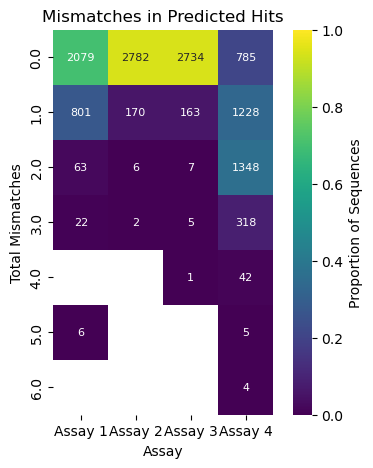

In [12]:
plot(heatmap_df, normalized_heatmap_df, 'Mismatches in Predicted Hits')
plt.savefig('mismatch.svg', dpi=300, bbox_inches='tight')

In [13]:
ev_txid = 12059
ev_txids = {'A': 138948, 'B': 138949, 'C': 138950, 'D': 138951}

# Read taxonomy species info 
ev_subspecies = pd.read_csv(collapse_file, sep='\t')

# Merge on to accessions 
ev_collapse = ev_data[['Accession', 'Virus Taxonomic ID']].merge(ev_subspecies, on='Virus Taxonomic ID', how='left')

# Merge mismatch data with species data 
assays_mismatches = [get_mismatches(file, ev_data).merge(ev_collapse) for file in assays]
assays_mismatches[0].head()

,Accession,Total Mismatches,Virus Taxonomic ID,Collapse TaxId,Collapse Name
0,AB705308.1,0.0,12062,138949,Enterovirus B
1,AB705309.1,0.0,12062,138949,Enterovirus B
2,AB705310.1,0.0,12062,138949,Enterovirus B
3,AB705311.1,0.0,12062,138949,Enterovirus B
4,AB769152.1,0.0,12089,138950,Enterovirus C


In [14]:
# Group by species 
assays_counts = [df.groupby(['Collapse Name', 'Total Mismatches']).size().reset_index(name='Count') for df, assay_name in zip(assays_mismatches, assay_names)]
assays_counts[0].head()

,Collapse Name,Total Mismatches,Count
0,Enterovirus A,0.0,1169
1,Enterovirus A,1.0,316
2,Enterovirus A,2.0,25
3,Enterovirus A,3.0,2
4,Enterovirus B,0.0,297


In [15]:
# Format data for facet grid

# Add column with assay name 
for df, name in zip(assays_counts, assay_names): 
    df['Assay'] = name
    
# Combine mismatch counts for all assays into a df
concated = pd.concat(assays_counts)
concated = concated[concated['Collapse Name'].str.contains('Enterovirus')]
concated.head()

,Collapse Name,Total Mismatches,Count,Assay
0,Enterovirus A,0.0,1169,Assay 1
1,Enterovirus A,1.0,316,Assay 1
2,Enterovirus A,2.0,25,Assay 1
3,Enterovirus A,3.0,2,Assay 1
4,Enterovirus B,0.0,297,Assay 1


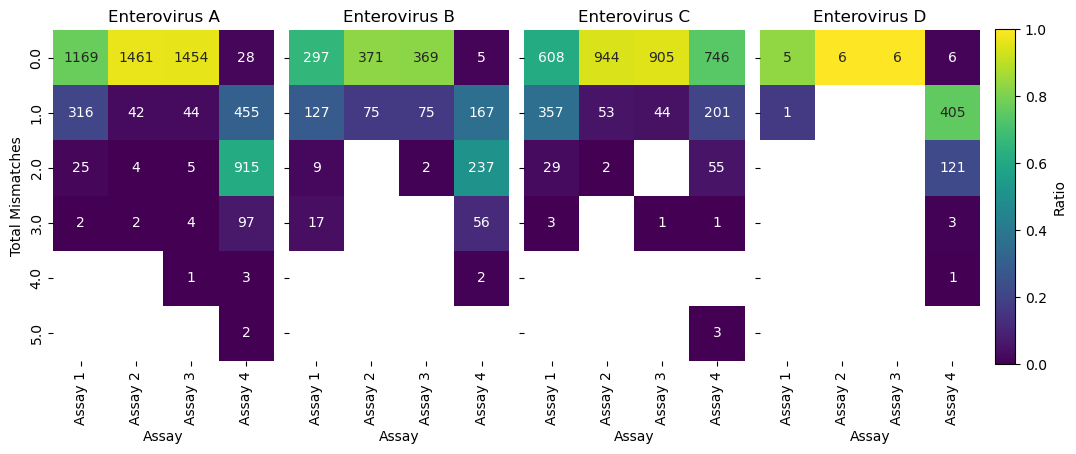

In [16]:
def draw_heatmap(data, **kwargs):
    data = data.pivot(index='Total Mismatches', columns='Assay', values='Count')
    data = data.reindex(index=mismatch_index)
    data = data.fillna(0)
    
    # Normalize data 
    normalized_data = data.div(data.sum(axis=0), axis=1)
    
    sns.heatmap(normalized_data, **kwargs, annot=data, fmt=".0f",cmap='viridis', cbar=False, mask=(data==0), vmax=1, vmin=0, square=True)

# Maintain consistent index 
mismatch_index = concated['Total Mismatches'].unique()

g = sns.FacetGrid(concated, col='Collapse Name')
g.fig.set_size_inches(10, 5)
g.map_dataframe(draw_heatmap)

# Set up legend 
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0, vmax=1))
cbar_ax = g.fig.add_axes([1, 0.21, 0.02, 0.67]) 
cbar = g.fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Ratio')

# Edit subplot titles 
for ax in g.axes.flat:
    title = ax.get_title().split('=')[-1].strip()
    ax.set_title(title)

plt.savefig('mismatch_subplot.svg', dpi=300, bbox_inches='tight')